In [1]:
# Import Packages and setup
import os
import logging
from astropy.table import Table as ApTable

import numpy as np

import scarlet
import scarlet.display

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
# use a better colormap and don't interpolate the pixels
matplotlib.rc('image', cmap='inferno')
matplotlib.rc('image', interpolation='none')

In [2]:
#idx = 18
idx = 0
#datapath = '/Users/fred/lsst/code/testdata_deblender/sim_data/psf_matched_sim'
#datapath = "/Users/fred/lsst/code/scarlet_paper/two_matched"
#datapath = "/Users/fred/lsst/code/scarlet_paper/single_matched"
datapath = "/Users/fred/lsst/code/scarlet_paper/real_matched"
data = np.load(os.path.join(datapath, 'images_{0}.npz'.format(idx)))
images = data["images"]
filters = data["filters"]
psfs = np.load(os.path.join(datapath, "psfs.npz"))["psfs"]
print("psf shape: {0}".format(psfs[0].shape))
catalog = ApTable.read(os.path.join(datapath, "true_catalog_{0}.fits".format(idx)))
coords = catalog['y','x', "is_star"]
bg_rms = np.array([20]*len(images))

psf shape: (31, 31)


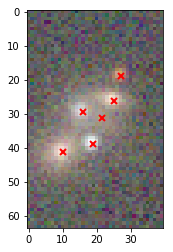

In [3]:
# Use Asinh scaling for the images
norm = scarlet.display.Asinh(img=images, Q=50)
# Map i,r,g -> RGB
filter_indices = [3,2,1]
# Convert the image to an RGB image
img_rgb = scarlet.display.img_to_rgb(images, filter_indices=filter_indices, norm=norm)
plt.imshow(img_rgb)
for src in catalog:
    plt.plot(src["x"], src["y"], "rx", mew=2)
plt.show()

In [5]:
sources = [scarlet.ExtendedSource((src['y'],src['x']), images, bg_rms, cpp=True) for src in catalog]
blend = scarlet.Blend(sources, images, bg_rms=bg_rms)
%time blend.fit(100, e_rel=.015)
print(blend.it)

CPU times: user 197 ms, sys: 2.47 ms, total: 200 ms
Wall time: 198 ms
48


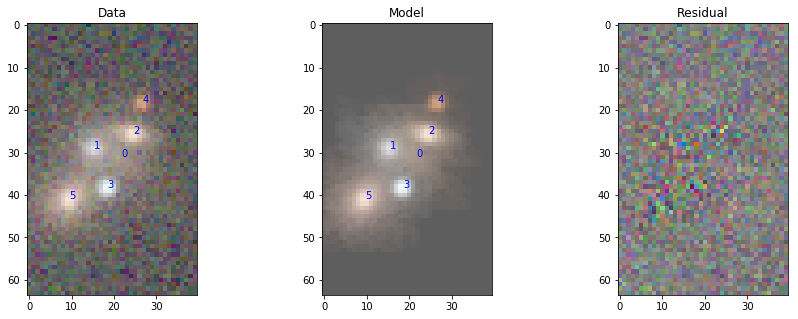

In [6]:
# Load the model and calculate the residual
model = blend.get_model()
residual = images-model
# Create RGB images
model_rgb = scarlet.display.img_to_rgb(model, filter_indices=filter_indices, norm=norm)
residual_rgb = scarlet.display.img_to_rgb(residual, filter_indices=filter_indices)

# Show the data, model, and residual
fig = plt.figure(figsize=(15,5))
ax = [fig.add_subplot(1,3,n+1) for n in range(3)]
ax[0].imshow(img_rgb)
ax[0].set_title("Data")
ax[1].imshow(model_rgb)
ax[1].set_title("Model")
ax[2].imshow(residual_rgb)
ax[2].set_title("Residual")
for m in range(len(blend.sources)):
    y,x = blend.sources[m].center
    ax[0].text(x, y, m, color="b")
    ax[1].text(x, y, m, color="b")
plt.show()

In [7]:
sources = [scarlet.PointSource((src['y'],src['x']), images, psf=psfs) for src in catalog]
blend = scarlet.Blend(sources, images, bg_rms=bg_rms)
%time blend.fit(100, e_rel=.015)
print("scarlet ran for {0} iterations".format(blend.it))

CPU times: user 1.15 s, sys: 3.3 ms, total: 1.15 s
Wall time: 1.15 s
scarlet ran for 56 iterations


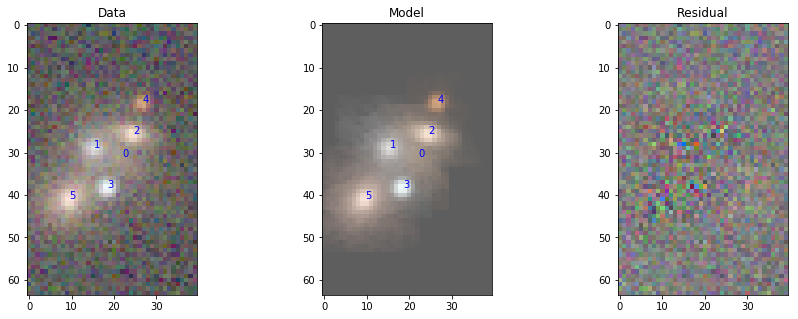

In [8]:
# Load the model and calculate the residual
model = blend.get_model()
residual = images-model
# Create RGB images
model_rgb = scarlet.display.img_to_rgb(model, filter_indices=filter_indices, norm=norm)
residual_rgb = scarlet.display.img_to_rgb(residual, filter_indices=filter_indices)

# Show the data, model, and residual
fig = plt.figure(figsize=(15,5))
ax = [fig.add_subplot(1,3,n+1) for n in range(3)]
ax[0].imshow(img_rgb)
ax[0].set_title("Data")
ax[1].imshow(model_rgb)
ax[1].set_title("Model")
ax[2].imshow(residual_rgb)
ax[2].set_title("Residual")
for m in range(len(blend.sources)):
    y,x = blend.sources[m].center
    ax[0].text(x, y, m, color="b")
    ax[1].text(x, y, m, color="b")
plt.show()

In [ ]:
X = blend.sources[0].morph

In [ ]:
%timeit np.zeros_like(X)
%timeit np.zeros(X.shape, dtype=X.dtype)

In [10]:
sources = [scarlet.PointSource((src['y'],src['x']), images, psf=psfs) for src in catalog]
blend = scarlet.Blend(sources, images, bg_rms=bg_rms)
%time blend.fit(40, e_rel=.015)
print("scarlet ran for {0} iterations".format(blend.it))

CPU times: user 985 ms, sys: 5.55 ms, total: 991 ms
Wall time: 990 ms
scarlet ran for 33 iterations


In [22]:
len(sources[0]._gamma.psfFilters[0]._slices[0])

961

In [9]:
sources = [scarlet.PointSource((src['y'],src['x']), images, psf=psfs, cpp=False) for src in catalog]
blend = scarlet.Blend(sources, images, bg_rms=bg_rms)
%time blend.fit(40, e_rel=.015)
print("scarlet ran for {0} iterations".format(blend.it))

CPU times: user 26.6 s, sys: 43.4 ms, total: 26.6 s
Wall time: 26.7 s
scarlet ran for 33 iterations


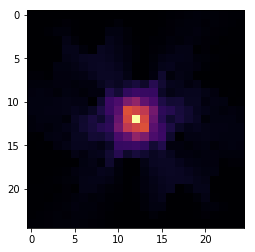

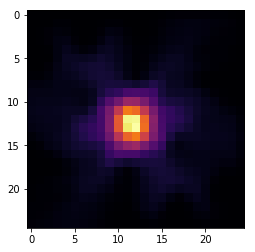

In [6]:
plt.imshow(blend.sources[0].morph[0])
plt.show()
slices = blend.sources[0].bb
plt.imshow(blend.get_model(m=0, use_sed=False, flat=False)[0][slices[1],slices[2]])
plt.show()

In [9]:
c1 = np.array([[0,0],[1,0],[0,1],[1,1]])
c2 = ((0,0),(1,0),(0,1),(1,1))
%timeit tuple(tuple(c) for c in c1)
%timeit np.array(c2)

5.25 µs ± 191 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
1.87 µs ± 10.1 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [9]:
%timeit blend._weights[1] * (blend._model-blend._img)

39.1 µs ± 645 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [10]:
%timeit 5 %2

13.8 ns ± 0.0911 ns per loop (mean ± std. dev. of 7 runs, 100000000 loops each)


In [8]:
coords = np.array([[0,0],[0,1], [1,0], [1,1]])
%timeit scarlet.transformations.get_filter_slices(coords)

10.9 µs ± 88.2 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [7]:
%timeit int(np.sign(.25))
%timeit 1 if .25>= 0 else -1

770 ns ± 1.94 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
48.1 ns ± 1.05 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


In [8]:
%timeit int(np.sign(-.25))
%timeit 1 if -.25>= 0 else -1

788 ns ± 29.3 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
44.8 ns ± 3.59 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


In [9]:
%timeit (np.abs(-.25))
%timeit abs(-.25)

635 ns ± 7.98 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
53.7 ns ± 0.44 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


In [8]:
coords = np.array([[0,0],[0,1],[1,0],[1,1]])
scarlet.transformations.get_cpp_filter_slices(-coords)

(array([0, 0, 0, 0]),
 array([0, 0, 1, 1]),
 array([0, 0, 0, 0]),
 array([0, 1, 0, 1]))